## Define problem

In [1]:
vmin=1364
vmax=6000 #thresholding 5990

h=25

nz=187; nx=801

dt=0.0025
nt=4000  #10 s

ntr=2000

In [2]:
import numpy as np
import matplotlib.pyplot as plt


z=np.arange(0,nz)*h
x=np.arange(0,nx)*h

def read(filename,n=(nx,nz)):
    return np.fromfile(filename,dtype='float32').reshape(n).T

def read_su(filename,n=(ntr,nt)):
    data=read(filename,n=(n[0],int(60+n[1])))
    return data[60:,:]

def imshow(data,perc=None,clip=None,clipmin=None,extent=None,cmap='viridis',title=None,title_colorbar=None,grid=True):
    if perc==None:
        clipp=[np.amin(data),np.amax(data)]
    else:
        tmp=np.percentile(np.abs(data),q=perc)
        clipp=[-tmp,tmp]
    
    if clip!=None: clipp=clip
    
    if clipmin!=None: clipp[0]=clipmin
    
    plt.imshow(data,vmin=clipp[0],vmax=clipp[1],cmap=cmap,extent=extent,aspect='auto')
    cbar=plt.colorbar(location='right')
    cbar=cbar.ax.set_ylabel(title_colorbar)
    if grid==True: plt.grid(visible=grid, axis='both', which='both', color='w', linestyle='--',linewidth=0.5)
    #plt.xlabel(labels[0]); plt.ylabel(labels[1])
    if title!=None: plt.title(title)

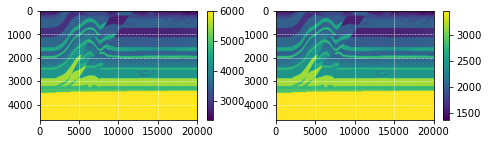

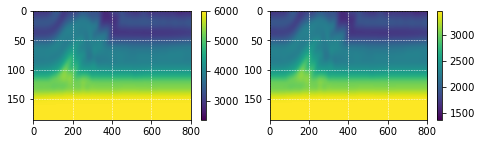

In [3]:
#plot
plt.figure(figsize=(12,2))
true=read('true',(3*nx,nz))
plt.subplot(1,3,1); imshow(true[:,:nx],clip=[2365,6000],extent=(0,(nx-1)*h,(nz-1)*h,0))
plt.subplot(1,3,2); imshow(true[:,nx:2*nx],clip=[1364,3462],extent=(0,(nx-1)*h,(nz-1)*h,0))

plt.figure(figsize=(12,2))
init=read('init',(3*nx,nz))
plt.subplot(1,3,1); imshow(init[:,:nx],clip=[2365,6000])
plt.subplot(1,3,2); imshow(init[:,nx:2*nx],clip=[1364,3462])

### more functions

In [4]:
from scipy.ndimage import gaussian_filter


def imshow_overlay(data1,data2,alpha=0.6,data1perc=None,data2perc=None,data1clip=None,data2clip=None,
                   cmap1='seismic',cmap2='gray',
                   extent=None,title=None,grid=True):
    if data1perc==None:
        clipp1=[np.amin(data1),np.amax(data1)]
    else:
        tmp=np.percentile(np.abs(data1),q=data1perc)
        clipp1=[-tmp,tmp]
    if data2perc==None:
        clipp2=[np.amin(data2),np.amax(data2)]
    else:
        tmp=np.percentile(np.abs(data2),q=data2perc)
        clipp2=[-tmp,tmp]
    
    if data1clip!=None: clipp1=data1clip
    if data2clip!=None: clipp2=data2clip
        
    plt.imshow(data1,vmin=clipp1[0],vmax=clipp1[1],            cmap=cmap1,extent=extent,aspect='auto')
    plt.imshow(data2,vmin=clipp2[0],vmax=0        ,alpha=alpha,cmap=cmap2,extent=extent,aspect='auto')
    
    #plt.colorbar(location='right')
    if grid==True: plt.grid(visible=grid, axis='both', which='both', color='y', linestyle='--',linewidth=0.5)
    #plt.xlabel(labels[0]); plt.ylabel(labels[1])
    if title!=None: plt.title(title)

def hilb_env(data):
    return np.abs(signal.hilbert(data,axis=0))

def normalize(data):
    out=np.zeros_like(data)
    amax=np.nanmax(data,axis=0)
    for i in range(amax.size):
        out[:,i]=data[:,i]/amax[i]
    return out
    
def amp_spec(data,axis=0):
    return np.abs(np.fft.rfft(data,axis=axis))

def smooth(data,sigma=(2,8)):
    return gaussian_filter(data,sigma=sigma)

def lat_avg(data):
    return np.mean(data,axis=1)

        

def make_FWDrun(app='FWD',np=28,nthreads=1,tag='',resdir='results',
                setup_more=[]):
    #!rm -fr $resdir
    exe='~/Codes/GitHub/SeisJIMU/exe/'+app
    #!rm run.slm; touch run.slm
    str=f"run_{tag}.sh"; print('bash '+str)
    #!cp /run/user/1001/gvfs/sftp:host=10.146.1.203,user=wei.zhou/cpgpfs/home/wei.zhou/run-compute.slm   $str
    !rm run_{tag}.sh
    ##
    #!sed -i 's/SBATCH --nodes=1/SBATCH --nodes=2/g' $str
    #!sed -i 's/#SBATCH --ntasks-per-node=28/#SBATCH --ntasks-per-node=14/g' $str
    ##
    with open(f"run_{tag}.sh", "a") as f:
        f.write(f"ulimit -s unlimited\n")
        f.write(f"export OMP_NUM_THREADS={nthreads}\n")
        f.write(f"rm -r {resdir}; mkdir -p {resdir} \n"),
        f.write(f"\n\n")
        ##
        f.write(f"cp setup_default setup_{tag}\n")
        f.write(f"echo \"DIR_OUT             \'{resdir}\'\"                     >> setup_{tag} \n")
        for i in range(len(setup_more)): f.write(f"echo \"{setup_more[i]}\"     >> setup_{tag} \n")
        f.write(f"mpirun --oversubscribe -np  {np}  {exe}  setup_{tag} > {resdir}/out \n")
        f.write(f"\n\n")
        
def make_FWIrun(app='FWI',np=28,nthreads=1,tag='',resdir='results',
                setup_more=[]):
    #!rm -fr $resdir
    exe='~/Codes/GitHub/SeisJIMU/exe/'+app
    #!rm run.slm; touch run.slm
    str=f"run_{tag}.sh"; print('bash '+str)
    #!cp /run/user/1001/gvfs/sftp:host=10.146.1.203,user=wei.zhou/cpgpfs/home/wei.zhou/run-compute.slm   $str
    !rm run_{tag}.sh
    ##
    #!sed -i 's/SBATCH --nodes=1/SBATCH --nodes=2/g' $str
    #!sed -i 's/#SBATCH --ntasks-per-node=28/#SBATCH --ntasks-per-node=14/g' $str
    ##
    with open(f"run_{tag}.sh", "a") as f:
        f.write(f"ulimit -s unlimited\n")
        f.write(f"export OMP_NUM_THREADS={nthreads}\n")
        f.write(f"rm -r {resdir}; mkdir -p {resdir} \n"),
        f.write(f"\n\n")
        ##
        f.write(f"cp setup_default setup_{tag}\n")
        f.write(f"echo \"DIR_OUT             \'{resdir}\'\"                     >> setup_{tag} \n")
        for i in range(len(setup_more)): f.write(f"echo \"{setup_more[i]}\"     >> setup_{tag} \n")
        f.write(f"mpirun --oversubscribe -np  {np}  {exe}  setup_{tag} > {resdir}/out \n")
        f.write(f"\n\n")


def make_FWDrun_ALFAHD(app='FWD',np=28,nthreads=1,tag='',resdir='results',
                setup_more=[]):
    #!rm -fr $resdir
    exe='/cpgpfs/home/wei.zhou/Codes/GitHub/SeisJIMU/exe/'+app
    #!rm run.slm; touch run.slm
    str=f"run_{tag}.slm"; print('slmsub '+str)
    !cp /run/user/1001/gvfs/sftp:host=10.146.1.203,user=wei.zhou/cpgpfs/home/wei.zhou/run-compute.slm   $str
    ##
    #!sed -i 's/SBATCH --nodes=1/SBATCH --nodes=2/g' $str
    #!sed -i 's/#SBATCH --ntasks-per-node=28/#SBATCH --ntasks-per-node=14/g' $str
    ##
    with open(f"run_{tag}.slm", "a") as f:
        f.write(f"ulimit -s unlimited\n")
        f.write(f"export OMP_NUM_THREADS={nthreads}\n")
        f.write(f"mkdir -p {resdir} \n"),
        f.write(f"\n\n")
        ##
        f.write(f"cp setup_default setup_{tag}\n")
        f.write(f"echo \"DIR_OUT             \'{resdir}\'\"                     >> setup_{tag} \n")
        for i in range(len(setup_more)): f.write(f"echo \"{setup_more[i]}\"     >> setup_{tag} \n")
        f.write(f"mpirun -np  {np}  {exe}  setup_{tag} > {resdir}/out \n")
        f.write(f"\n\n")

def make_FWIrun_ALFAHD(app='FWI',np=28,nthreads=1,tag='',resdir='results',
                setup_more=[]):
    #!rm -fr $resdir
    exe='/cpgpfs/home/wei.zhou/Codes/GitHub/SeisJIMU/exe/'+app
    #!rm run.slm; touch run.slm
    str=f"run_{tag}.slm"; print('slmsub '+str)
    !cp /run/user/1001/gvfs/sftp:host=10.146.1.203,user=wei.zhou/cpgpfs/home/wei.zhou/run-compute.slm   $str
    ##
    #!sed -i 's/SBATCH --nodes=1/SBATCH --nodes=2/g' $str
    #!sed -i 's/#SBATCH --ntasks-per-node=28/#SBATCH --ntasks-per-node=14/g' $str
    ##
    with open(f"run_{tag}.slm", "a") as f:
        f.write(f"ulimit -s unlimited\n")
        f.write(f"export OMP_NUM_THREADS={nthreads}\n")
        f.write(f"mkdir -p {resdir} \n"),
        f.write(f"\n\n")
        ##
        f.write(f"cp setup_default setup_{tag}\n")
        f.write(f"echo \"DIR_OUT             \'{resdir}\'\"                     >> setup_{tag} \n")
        for i in range(len(setup_more)): f.write(f"echo \"{setup_more[i]}\"     >> setup_{tag} \n")
        f.write(f"mpirun -np  {np}  {exe}  setup_{tag} > {resdir}/out \n")
        f.write(f"\n\n")
        
        
# def make_FWIrun(app='FWI',np=31,nthreads=2,tag='',resdir='results',
#                 data_prefix='split_fldr',
#                 vp0=f'vp_2layer2_smth.{h}m',
#                 wl_more=[],vp_more=[],cycles=[1,3]):
#     #!rm -fr $resdir
#     ##
#     !cp {vp0} init{tag}
#     exe='../SeisJIMU/exe/'+app
#     #!rm run.slm; touch run.slm
#     str=f"run{tag}.slm"; print('slmsub '+str)
#     !cp /run/user/1001/gvfs/sftp:host=10.146.1.203,user=wei.zhou/cpgpfs/home/wei.zhou/run-compute-phi.slm   $str
#     ##
#     with open(f"run{tag}.slm", "a") as f:
#         f.write(f"ulimit -s unlimited\n")
#         f.write(f"export OMP_NUM_THREADS={nthreads}\n")
#         f.write(f"\n\n")
#         ##
#         f.write(f"mkdir -p {resdir}/C0_Vp && cp {vp0} {resdir}/C0_Vp/model_final \n"),
#         f.write(f"\n\n")
#         ##
#         for c in range(cycles[0],cycles[1]+1):
#             f.write(f"######\n")
#             f.write(f"cc={c}\n")
#             f.write(f"######\n")
#             ###
#             f.write(f"echo \"on CYCLE $cc WL\" \n")
#             f.write(f"cp setup_default setup_wl{tag}\n")
#             f.write(f"echo \"DIR_OUT             \'{resdir}/C{c}_WL\'\"                   >> setup_wl{tag} \n")
#             f.write(f"echo \"FILE_MODEL          \'{resdir}/C{c-1}_Vp/model_final\' \"    >> setup_wl{tag} \n")
#             f.write(f"echo \"MODEL_SIZE          \'{nz}  {nx}  1  \'\"                    >> setup_wl{tag} \n")
#             f.write(f"echo \"MODEL_SPACING       \'{h}   {h}   {h}\'\"                    >> setup_wl{tag} \n")
#             f.write(f"echo \"FILE_DATA_PREFIX    \'{data_prefix}\'  \"                    >> setup_wl{tag} \n")
#             f.write(f"echo \"FPEAK                 {f3}\"                                 >> setup_wl{tag} \n")
#             f.write(f"echo \"JOB                \'gradient'\"                             >> setup_wl{tag} \n")
#             for i in range(len(wl_more)): f.write(f"echo \"{wl_more[i]}\"                 >> setup_wl{tag} \n")
#             f.write(f"mpirun -np  {np}  {exe}  setup_wl{tag} > {resdir}/out_C{c}_wl \n")
#             f.write(f"#------------\n")
#             ###
#             f.write(f"echo \"on CYCLE $cc Vp\" \n")
#             f.write(f"cp setup_default setup_vp{tag}\n")
#             f.write(f"echo \"DIR_OUT             \'{resdir}/C{c}_Vp\'\"                      >> setup_vp{tag} \n")
#             f.write(f"echo \"FILE_MODEL          \'{resdir}/C{c-1}_Vp/model_final\'\"        >> setup_vp{tag} \n")
#             f.write(f"echo \"MODEL_SIZE          \'{nz}  {nx}  1  \'\"                       >> setup_vp{tag} \n")
#             f.write(f"echo \"MODEL_SPACING       \'{h}   {h}   {h}\'\"                       >> setup_vp{tag} \n")
#             f.write(f"echo \"FILE_DATA_PREFIX    \'{data_prefix}\'  \"                       >> setup_vp{tag} \n")
#             f.write(f"echo \"FPEAK                 {f3}\"                                    >> setup_vp{tag} \n")
#             f.write(f"echo \"FILE_WAVELET_PREFIX \'{resdir}/C{c}_WL/updated_wavelet_Shot\'\" >> setup_vp{tag} \n")
#             f.write(f"echo \"UPDATE_WAVELET        no \"                                     >> setup_vp{tag} \n")
#             f.write(f"echo \"JOB                 \'optimization\'\"                          >> setup_vp{tag} \n")
#             for i in range(len(vp_more)): f.write(f"echo \"{vp_more[i]}\"                    >> setup_vp{tag} \n")
#             f.write(f"mpirun -np  {np}  {exe}  setup_vp{tag} > {resdir}/out_C{c}_vp \n")
#             f.write(f"\n\n")

def make_RTMrun(app='FWI',np=112,nthreads=1,tag='',resdir='results',
                data_prefix='split_fldr',
                vp0=f'vp_2layer2_smth.{h}m',
                setup_more=[]):
    #!rm -fr $resdir
    exe='../SeisJIMU/exe/'+app
    #!rm run.slm; touch run.slm
    str=f"run{tag}.slm"; print('slmsub '+str)
    !cp /run/user/1001/gvfs/sftp:host=10.146.1.203,user=wei.zhou/cpgpfs/home/wei.zhou/run-compute-phi.slm   $str
    ##
    with open(f"run{tag}.slm", "a") as f:
        f.write(f"ulimit -s unlimited\n")
        f.write(f"export OMP_NUM_THREADS={nthreads}\n")
        f.write(f"mkdir -p {resdir} \n"),
        f.write(f"\n\n")
        ##
        f.write(f"cp setup_default setup_rtm{tag}\n")
        f.write(f"echo \"DIR_OUT             \'{resdir}\'\"                     >> setup_rtm{tag} \n")
        f.write(f"echo \"FILE_MODEL          \'{vp0}\'\"                        >> setup_rtm{tag} \n")
        f.write(f"echo \"MODEL_SIZE          \'{nz}  {nx}  1  \'\"              >> setup_rtm{tag} \n")
        f.write(f"echo \"MODEL_SPACING       \'{h}   {h}   {h}\'\"              >> setup_rtm{tag} \n")
        f.write(f"echo \"FILE_DATA_PREFIX    \'{data_prefix}\'  \"              >> setup_rtm{tag} \n")
        f.write(f"echo \"FPEAK                 {f3}\"                           >> setup_rtm{tag} \n")
        f.write(f"echo \"DNORM                 imaging\"                        >> setup_rtm{tag} \n")
        f.write(f"echo \"SMTH                  none\"                           >> setup_rtm{tag} \n")
        f.write(f"echo \"JOB                 \'gradient\'\"                     >> setup_rtm{tag} \n")
        for i in range(len(setup_more)): f.write(f"echo \"{setup_more[i]}\"     >> setup_rtm{tag} \n")
        f.write(f"mpirun -np  {np}  {exe}  setup_rtm{tag} > {resdir}/out \n")
        f.write(f"\n\n")

def run_local(app='FWI',np=8,nthreads=1,tag='',resdir='results',
              data_prefix='split_fldr',
              vp0=f'vp_2layer2_smth.{h}m',vp_more=[]):
    !rm -fr /home/wzhou/tmp
    ##
    !cp $vp0 init$tag
    exe='~/Codes/GitHub/SeisJIMU/exe/'+app
    ##
    !rm run{tag}.sh
    str=f"run{tag}.sh"; print('bash '+str)
    ##
    with open(f"run{tag}.sh", "a") as f:
        f.write(f"ulimit -s unlimited\n")
        f.write(f"export OMP_NUM_THREADS={nthreads}\n")
        f.write(f"\n\n")
        ##
        f.write(f"cp {vp0} init{tag} \n"),
        f.write(f"\n\n")
        ##
        f.write(f"cp setup_default setup{tag}\n")
        f.write(f"echo \"DIR_OUT             \' /home/wzhou/tmp\' \"   >> setup{tag} \n")
        f.write(f"echo \"FILE_MODEL          \'init{tag}\'          \" >> setup{tag} \n")
        f.write(f"echo \"MODEL_SIZE          \'{nz}  {nx}  1  \'    \" >> setup{tag} \n")
        f.write(f"echo \"MODEL_SPACING       \'{h}   {h}   {h}\'    \" >> setup{tag} \n")
        f.write(f"echo \"FPEAK                 {f3}                 \" >> setup{tag} \n")
        for i in range(len(vp_more)): f.write(f"echo \"{vp_more[i]}\"  >> setup{tag} \n")
        f.write(f"mpirun -np  {np}  {exe}  setup{tag} > out{tag} \n")
        f.write(f"\n\n")
    ##
    !bash run.sh
    !mv /home/wzhou/tmp {resdir}

In [5]:
#!lda = rho(vp^2-2vs^2)
#!mu  = rho*vs^2
#!rho0= rho
#!gvp = glda*2rho*vp
#!gvs = (glda*-2 + gmu)*2rho*vs
#!grho= glda*vp^2 + (-2glda+gmu)*vs^2 + grho0
vp=init[:,:nx]
vs=init[:,nx:2*nx]
rho=1.
def chain(glda,gmu):
    gvp= glda            *2*rho*vp
    gvs=(glda*(-2) + gmu)*2*rho*vs
    return gvp,gvs

In [6]:
z=np.arange(0,nz)*h
zpow=np.power(z,2)
zpow=np.tile(zpow,(nx,1)).T

## Observed data

In [7]:
# make_FWDrun(resdir='res_obs',tag='obs',setup_more=[
#     "SCOMP          pz",
#     "RCOMP   'pz px ex'"
# ]) #1.38min

bash run_obs.sh
rm: cannot remove 'run_obs.sh': No such file or directory


In [48]:
# make_FWDrun(app='fwd_PSV_FDSG_O4_',resdir='resVS_obs',tag='obs',setup_more=[
#     "SCOMP          vz",
#     "RCOMP      'vz vx'"
# ]) #1.38min

bash run_obs.sh


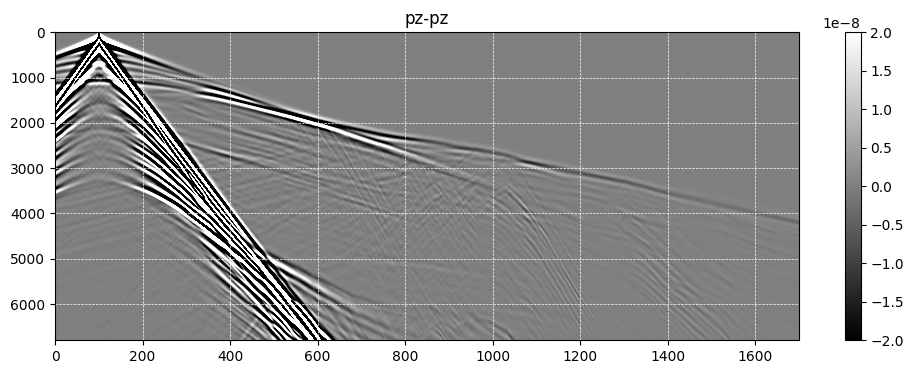

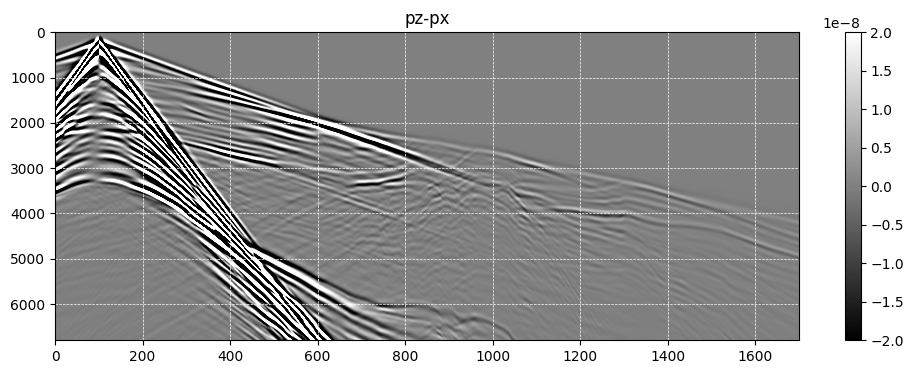

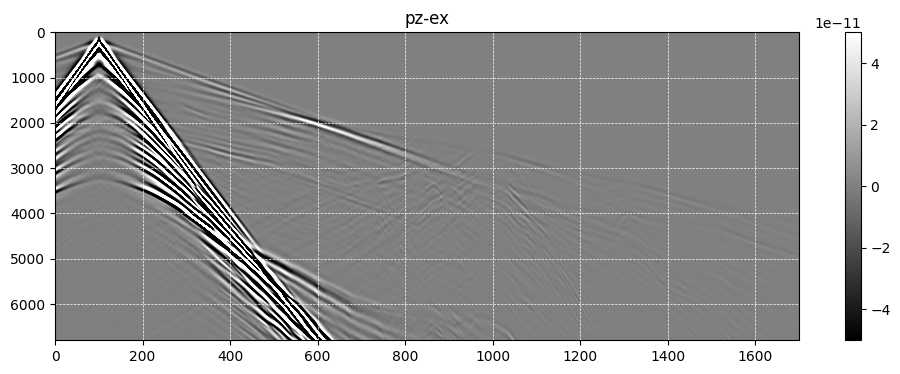

In [9]:
plt.figure(figsize=(12,4))
!suwind < res_obs/Ru_Shot0001.su key=trid min=32 max=32 > obs0001.su
imshow(read_su('obs0001.su'),clip=(-2e-8,2e-8),title='pz-pz',cmap='gray')

plt.figure(figsize=(12,4))
!suwind < res_obs/Ru_Shot0001.su key=trid min=34 max=34 > obs0001.su
imshow(read_su('obs0001.su'),clip=(-2e-8,2e-8),title='pz-px',cmap='gray')

plt.figure(figsize=(12,4))
!suwind < res_obs/Ru_Shot0001.su key=trid min=22 max=22 > obs0001.su
imshow(read_su('obs0001.su'),clip=(-5e-11,5e-11),title='pz-ex',cmap='gray')

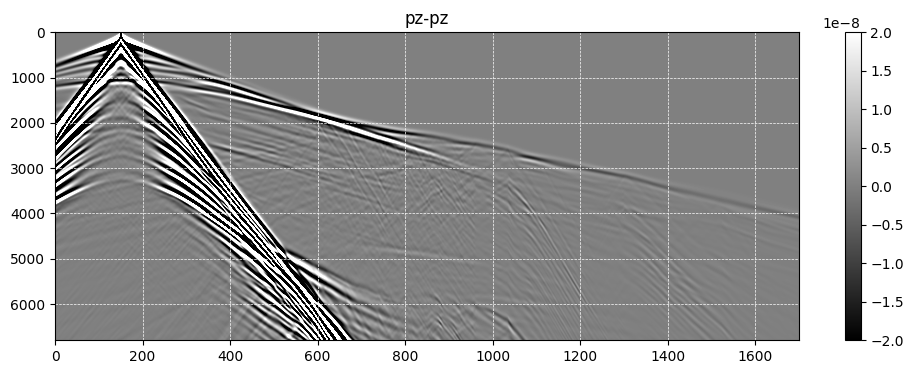

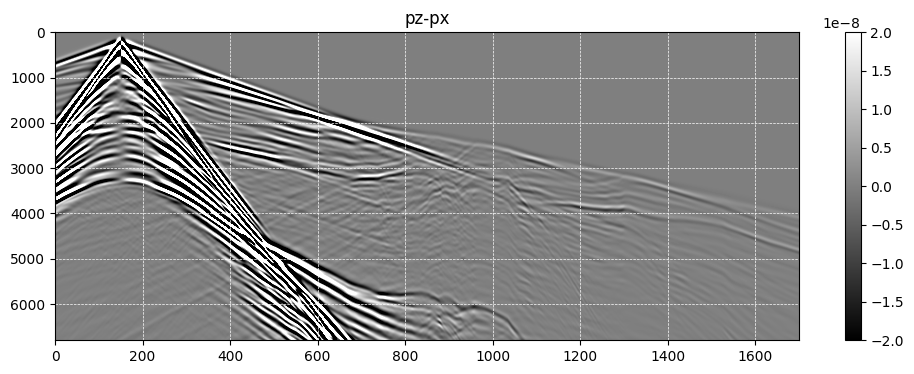

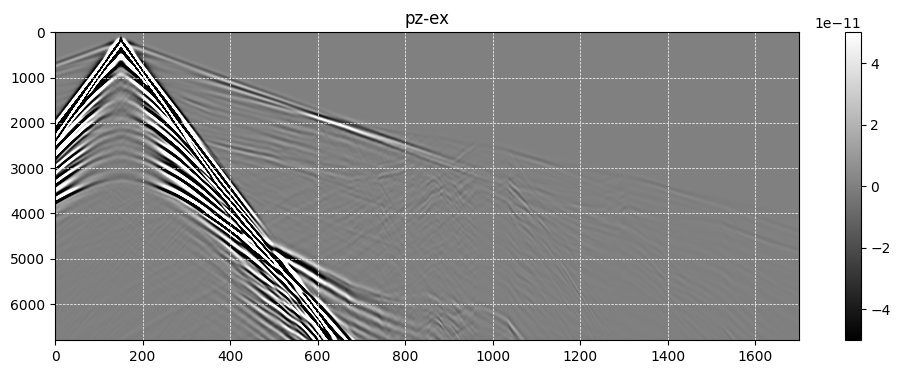

In [10]:
plt.figure(figsize=(12,4))
!suwind < res_obs/Ru_Shot0002.su key=trid min=32 max=32 > obs0002.su
imshow(read_su('obs0002.su'),clip=(-2e-8,2e-8),title='pz-pz',cmap='gray')

plt.figure(figsize=(12,4))
!suwind < res_obs/Ru_Shot0002.su key=trid min=34 max=34 > obs0002.su
imshow(read_su('obs0002.su'),clip=(-2e-8,2e-8),title='pz-px',cmap='gray')

plt.figure(figsize=(12,4))
!suwind < res_obs/Ru_Shot0002.su key=trid min=22 max=22 > obs0002.su
imshow(read_su('obs0002.su'),clip=(-5e-11,5e-11),title='pz-ex',cmap='gray')

### test performance

In [ ]:
make_FWDrun(resdir='results_test',tag='test',np=14,nthreads=1,setup_more=[
    "NT       1000 ",
    "NS       14   ",
    "SCOMP          pz",
    "RCOMP   'pz px ex'"
]) #--> 52909, 1node, 14proc, 1thrd/proc, no #SBATCH --ntasks-per-node=14
   #elapsed 0.2277min


In [ ]:
make_FWDrun(resdir='results_test2',tag='test2',np=14,nthreads=2,setup_more=[
    "NT       1000 ",
    "NS       14   ",
    "SCOMP          pz",
    "RCOMP   'pz px ex'"
]) #--> 52912, 1node, 14proc, 2thrd/proc, no #SBATCH --ntasks-per-node=14
   #elapsed 0.2092min


In [ ]:
make_FWIrun(resdir='results_test3',tag='test3',np=14,nthreads=1,setup_more=[
    "FILE_MODEL          'init'",
    "FILE_DATA_PREFIX    'results_test/Ru'",
    "NBATCH               14",
    "SCOMP                pz"
]) #--> 52918, 1node, 14proc, 1thrd/proc, no #SBATCH --ntasks-per-node=14
   #elapsed

In [ ]:
make_FWIrun(resdir='results_test4',tag='test4',np=14,nthreads=2,setup_more=[
    "FILE_MODEL          'init'",
    "FILE_DATA_PREFIX    'results_test/Ru'",
    "NBATCH               14",
    "SCOMP                pz"
]) #--> 52929, 1node, 14proc, 1thrd/proc, no #SBATCH --ntasks-per-node=14
   #elapsed

## Initial=init

### pz-ex

In [9]:
#!cd res_obs; for su in `ls Ru_Shot00??.su`; do suwind < $su key=trid min=22 max=22 > ex_$su; done

make_FWIrun_ALFAHD(resdir='res_pz-ex',tag='10',np=20,nthreads=1,setup_more=[
    "FILE_MODEL          'init'",
    "FILE_DATA_PREFIX    'res_obs/ex_Ru_Shot'",
    "NBATCH               39",
    "SCOMP                pz",
    "PARAMETER           'vs:1364:3462'",
    "SMOOTHING            Laplacian", "LAP_FRAC      '0.1 0.1 0.1'",
    "JOB                  optimization "
]) #--> 53495

make_FWIrun_ALFAHD(resdir='res_pz-ex_2para',tag='11',np=20,nthreads=1,setup_more=[
    "FILE_MODEL          'init'",
    "FILE_DATA_PREFIX    'res_obs/ex_Ru_Shot'",
    "NBATCH               39",
    "SCOMP                pz",
    "PARAMETER           'vp:2365:5990 vs:1364:3462'",
    "SMOOTHING            Laplacian", "LAP_FRAC      '0.1 0.1 0.1'",
    "JOB                  optimization "
]) #--> 53496

make_FWIrun_ALFAHD(resdir='res_pz-ex_2parascal',tag='12',np=20,nthreads=1,setup_more=[
    "FILE_MODEL          'init'",
    "FILE_DATA_PREFIX    'res_obs/ex_Ru_Shot'",
    "NBATCH               39",
    "SCOMP                pz",
    "PARAMETER           'vp:2365:5990 vs:1364:3462'",
    "IF_PARA_SCAL         T",
    "SMOOTHING            Laplacian", "LAP_FRAC      '0.1 0.1 0.1'",
    "JOB                  optimization "
]) #--> 53498

slmsub run_10.slm
slmsub run_11.slm
slmsub run_12.slm


In [14]:
!cat res_pz-ex/optimization.log

 **********************************************************************
    LIMITED-MEMORY BFGS ALGORITHM
 **********************************************************************
     Min descent allowed      =1.0000E-08
     Max iterates allowed     =  120
     Max linesearches allowed =   12
     Max gradients allowed    =  150
     Linesearch scaler        =2.32189412E+20
     Initial gradient L1norm (║g0║₁)  =7.1394E+01
 **********************************************************************
         LinS#  Grad#     α    pert%       f                            g·d   Wolfe_cond
  Iter#         Grad#          curr%       f    f/f0(%) ║g║₁/║g0║₁(%)   g·d
     0             1                 1.0276E+02 100.000  100.000     -8.23E-02
            1      2  1.00E+00       9.9142E+01                      -8.54E-02    T  F
            2      3  1.00E+01       6.9813E+01                      -3.30E-02    T  T
     1             3                 6.9813E+01  67.935   52.684     -4.01E-01
 ---

In [8]:
!cat res_pz-ex_2para/optimization.log

 **********************************************************************
    LIMITED-MEMORY BFGS ALGORITHM
 **********************************************************************
     Min descent allowed      =1.0000E-08
     Max iterates allowed     =  120
     Max linesearches allowed =   12
     Max gradients allowed    =  150
     Linesearch scaler        =4.07477306E+21
     Initial gradient L1norm (║g0║₁)  =1.2949E+03
 **********************************************************************
         LinS#  Grad#     α    pert%       f                            g·d   Wolfe_cond
  Iter#         Grad#          curr%       f    f/f0(%) ║g║₁/║g0║₁(%)   g·d
     0             1                 1.8035E+03 100.000  100.000     -2.54E+01
            1      2  1.00E+00       1.1530E+03                       1.04E+01    T  T
     1             2                 1.1530E+03  63.931   45.705     -4.75E+00
 ----------------------------------------------------------------------------------------
 

In [13]:
!cat res_pz-ex_2parascal/optimization.log

 **********************************************************************
    LIMITED-MEMORY BFGS ALGORITHM
 **********************************************************************
     Min descent allowed      =1.0000E-08
     Max iterates allowed     =  120
     Max linesearches allowed =   12
     Max gradients allowed    =  150
     Linesearch scaler        =1.34306744E+20
     Initial gradient L1norm (║g0║₁)  =4.2682E+01
 **********************************************************************
         LinS#  Grad#     α    pert%       f                            g·d   Wolfe_cond
  Iter#         Grad#          curr%       f    f/f0(%) ║g║₁/║g0║₁(%)   g·d
     0             1                 5.9443E+01 100.000  100.000     -2.83E-02
            1      2  1.00E+00       5.8215E+01                      -2.90E-02    T  F
            2      3  1.00E+01       4.6928E+01                      -2.52E-02    T  T
     1             3                 4.6928E+01  78.947   91.041     -2.82E+00
 ---

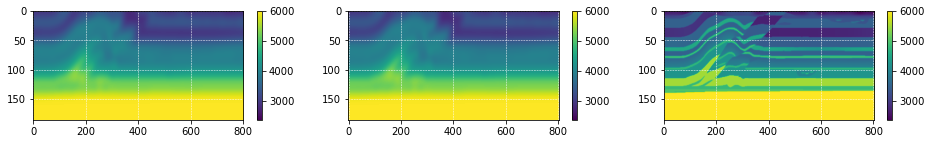

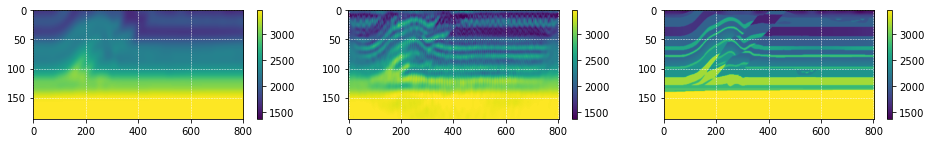

In [15]:
#plot
res=read('res_pz-ex/model_final',n=(3*nx,nz))

clip=[2365,6000]
plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(init[:,:nx],clip=clip)
plt.subplot(1,3,2); imshow(res[:,:nx],clip=clip)
plt.subplot(1,3,3); imshow(true[:,:nx],clip=clip)

clip=[1364,3462]
plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(init[:,nx:2*nx],clip=clip)
plt.subplot(1,3,2); imshow(res[:,nx:2*nx],clip=clip)
plt.subplot(1,3,3); imshow(true[:,nx:2*nx],clip=clip)

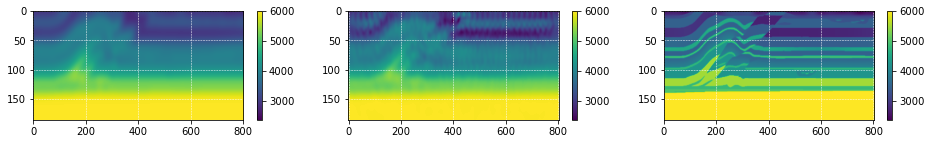

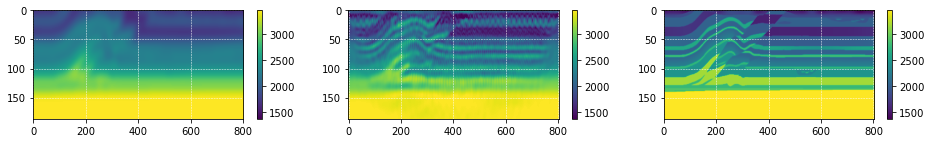

In [14]:
#plot
res=read('res_pz-ex_2para/model_final',n=(3*nx,nz))

clip=[2365,6000]
plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(init[:,:nx],clip=clip)
plt.subplot(1,3,2); imshow(res[:,:nx],clip=clip)
plt.subplot(1,3,3); imshow(true[:,:nx],clip=clip)

clip=[1364,3462]
plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(init[:,nx:2*nx],clip=clip)
plt.subplot(1,3,2); imshow(res[:,nx:2*nx],clip=clip)
plt.subplot(1,3,3); imshow(true[:,nx:2*nx],clip=clip)

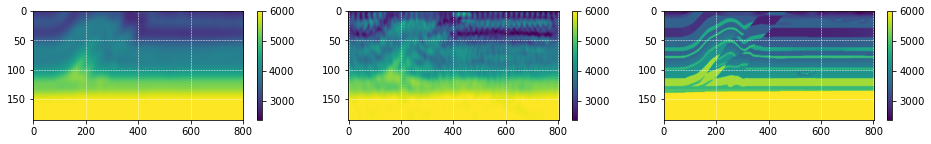

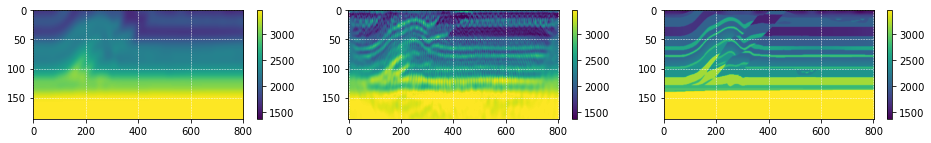

In [16]:
#plot
res=read('res_pz-ex_2parascal/model_final',n=(3*nx,nz))

clip=[2365,6000]
plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(init[:,:nx],clip=clip)
plt.subplot(1,3,2); imshow(res[:,:nx],clip=clip)
plt.subplot(1,3,3); imshow(true[:,:nx],clip=clip)

clip=[1364,3462]
plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(init[:,nx:2*nx],clip=clip)
plt.subplot(1,3,2); imshow(res[:,nx:2*nx],clip=clip)
plt.subplot(1,3,3); imshow(true[:,nx:2*nx],clip=clip)

### pz-px

In [28]:
#!cd res_obs; for su in `ls Ru_Shot00??.su`; do suwind < $su key=trid min=34 max=34 > px_$su; done

# make_FWIrun_ALFAHD(resdir='res_pz-px',tag='10',np=20,nthreads=1,setup_more=[
#     "FILE_MODEL          'init'",
#     "FILE_DATA_PREFIX    'res_obs/px_Ru_Shot'",
#     "NBATCH               39",
#     "SCOMP                pz",
#     "PARAMETER           'vs:1364:3462'",
#     "SMOOTHING            Laplacian", "LAP_FRAC      '0.1 0.1 0.1'",
#     "JOB                  optimization "
# ]) #--> 53495

# make_FWIrun_ALFAHD(resdir='res_pz-px_2para',tag='11',np=20,nthreads=1,setup_more=[
#     "FILE_MODEL          'init'",
#     "FILE_DATA_PREFIX    'res_obs/px_Ru_Shot'",
#     "NBATCH               39",
#     "SCOMP                pz",
#     "PARAMETER           'vp:2365:5990 vs:1364:3462'",
#     "SMOOTHING            Laplacian", "LAP_FRAC      '0.1 0.1 0.1'",
#     "JOB                  optimization "
# ]) #--> 53496

make_FWIrun_ALFAHD(resdir='res_pz-px_2parascal',tag='22',np=20,nthreads=1,setup_more=[
    "FILE_MODEL          'init'",
    "FILE_DATA_PREFIX    'res_obs/px_Ru_Shot'",
    "NBATCH               39",
    "SCOMP                pz",
    "PARAMETER           'vp:2365:5990 vs:1364:3462'",
    "IF_PARA_SCAL         T",
    "SMOOTHING            Laplacian", "LAP_FRAC      '0.1 0.1 0.1'",
    "JOB                  optimization "
]) #--> 53550

slmsub run_22.slm


In [15]:
!cat res_pz-px_2parascal/optimization.log

 **********************************************************************
    LIMITED-MEMORY BFGS ALGORITHM
 **********************************************************************
     Min descent allowed      =1.0000E-08
     Max iterates allowed     =  120
     Max linesearches allowed =   12
     Max gradients allowed    =  150
     Linesearch scaler        =2.81449144E+13
     Initial gradient L1norm (║g0║₁)  =4.4884E+01
 **********************************************************************
         LinS#  Grad#     α    pert%       f                            g·d   Wolfe_cond
  Iter#         Grad#          curr%       f    f/f0(%) ║g║₁/║g0║₁(%)   g·d
     0             1                 5.6869E+01 100.000  100.000     -2.62E-02
            1      2  1.00E+00       5.5798E+01                      -2.66E-02    T  F
            2      3  1.00E+01       4.5896E+01                      -2.41E-02    T  F
            3      4  1.00E+02       5.9889E+01                      -5.48E-03    F

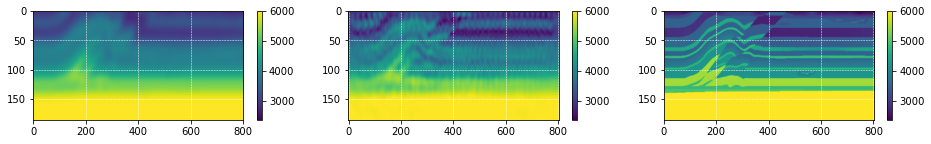

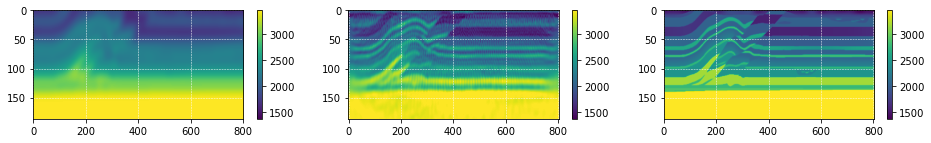

In [16]:
#plot
res=read('res_pz-px_2parascal/model_final',n=(3*nx,nz))

clip=[2365,6000]
plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(init[:,:nx],clip=clip)
plt.subplot(1,3,2); imshow(res[:,:nx],clip=clip)
plt.subplot(1,3,3); imshow(true[:,:nx],clip=clip)

clip=[1364,3462]
plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(init[:,nx:2*nx],clip=clip)
plt.subplot(1,3,2); imshow(res[:,nx:2*nx],clip=clip)
plt.subplot(1,3,3); imshow(true[:,nx:2*nx],clip=clip)

### compar ex vs px

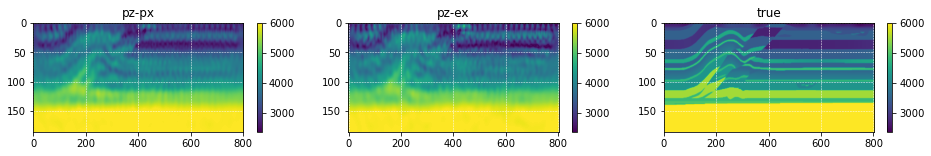

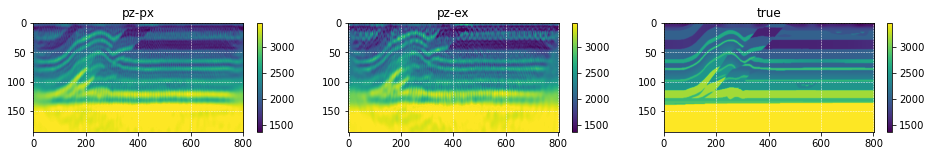

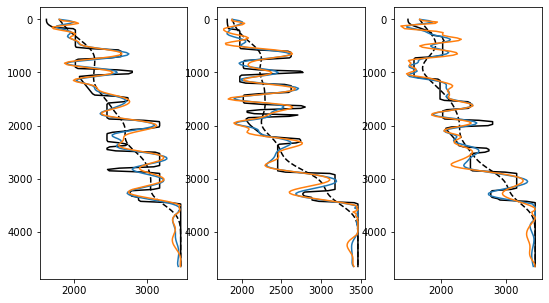

In [10]:
#plot
res1=read('res_pz-px_2parascal/model_Iter54',n=(3*nx,nz))
res2=read('res_pz-ex_2parascal/model_Iter65',n=(3*nx,nz))

clip=[2365,6000]
plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(res1[:,:nx],clip=clip); plt.title("pz-px")
plt.subplot(1,3,2); imshow(res2[:,:nx],clip=clip); plt.title("pz-ex")
plt.subplot(1,3,3); imshow(true[:,:nx],clip=clip); plt.title("true")

clip=[1364,3462]
plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(res1[:,nx:2*nx],clip=clip); plt.title("pz-px")
plt.subplot(1,3,2); imshow(res2[:,nx:2*nx],clip=clip); plt.title("pz-ex")
plt.subplot(1,3,3); imshow(true[:,nx:2*nx],clip=clip); plt.title("true")

plt.figure(figsize=(9,5))
plt.subplot(1,3,1); ix=200
plt.plot(true[:,nx+ix],z,'k'); plt.plot(init[:,nx+ix],z,'k--'); plt.plot(res1[:,nx+ix],z); plt.plot(res2[:,nx+ix],z)
# plt.xlim([300,1300])
plt.gca().invert_yaxis()

plt.subplot(1,3,2); ix=300
plt.plot(true[:,nx+ix],z,'k'); plt.plot(init[:,nx+ix],z,'k--'); plt.plot(res1[:,nx+ix],z); plt.plot(res2[:,nx+ix],z)
# plt.xlim([600,1600])
plt.gca().invert_yaxis()

plt.subplot(1,3,3); ix=600
plt.plot(true[:,nx+ix],z,'k'); plt.plot(init[:,nx+ix],z,'k--'); plt.plot(res1[:,nx+ix],z); plt.plot(res2[:,nx+ix],z)
# plt.xlim([300,1300])
plt.gca().invert_yaxis()

### pz-pzpx

In [23]:
#!cd res_obs; for su in `ls Ru_Shot00??.su`; do suwind < $su key=trid min=34 max=34 > px_$su; done

# make_FWIrun_ALFAHD(resdir='res_pz-px',tag='10',np=20,nthreads=1,setup_more=[
#     "FILE_MODEL          'init'",
#     "FILE_DATA_PREFIX    'res_obs/px_Ru_Shot'",
#     "NBATCH               39",
#     "SCOMP                pz",
#     "PARAMETER           'vs:1364:3462'",
#     "SMOOTHING            Laplacian", "LAP_FRAC      '0.1 0.1 0.1'",
#     "JOB                  optimization "
# ]) #--> 53495

# make_FWIrun_ALFAHD(resdir='res_pz-px_2para',tag='11',np=20,nthreads=1,setup_more=[
#     "FILE_MODEL          'init'",
#     "FILE_DATA_PREFIX    'res_obs/px_Ru_Shot'",
#     "NBATCH               39",
#     "SCOMP                pz",
#     "PARAMETER           'vp:2365:5990 vs:1364:3462'",
#     "SMOOTHING            Laplacian", "LAP_FRAC      '0.1 0.1 0.1'",
#     "JOB                  optimization "
# ]) #--> 53496

make_FWIrun_ALFAHD(resdir='res_pz-pzpx_2parascal',tag='32',np=20,nthreads=1,setup_more=[
    "FILE_MODEL          'init'",
    "FILE_DATA_PREFIX    'res_obs/pzpx_Ru_Shot'",
    "NBATCH               39",
    "SCOMP                pz",
    "PARAMETER           'vp:2365:5990 vs:1364:3462'",
    "IF_PARA_SCAL         T",
    "SMOOTHING            Laplacian", "LAP_FRAC      '0.1 0.1 0.1'",
    "JOB                  optimization "
]) #--> 53551

make_FWIrun_ALFAHD(resdir='res_pz-pzpx_2parascal_contd',tag='32b',np=20,nthreads=1,setup_more=[
    "FILE_MODEL          'res_pz-pzpx_2parascal/model_Iter9'",
    "FILE_DATA_PREFIX    'res_obs/pzpx_Ru_Shot'",
    "NBATCH               39",
    "SCOMP                pz",
    "PARAMETER           'vp:2365:5990 vs:1364:3462'",
    "IF_PARA_SCAL         T",
    "SMOOTHING            Laplacian", "LAP_FRAC      '0.1 0.1 0.1'",
    "JOB                  optimization "
]) #--> 53561

slmsub run_32.slm
slmsub run_32b.slm


In [17]:
!cat res_pz-pzpx_2parascal/optimization.log

 **********************************************************************
    LIMITED-MEMORY BFGS ALGORITHM
 **********************************************************************
     Min descent allowed      =1.0000E-08
     Max iterates allowed     =  120
     Max linesearches allowed =   12
     Max gradients allowed    =  150
     Linesearch scaler        =8.15452232E+12
     Initial gradient L1norm (║g0║₁)  =4.4202E+01
 **********************************************************************
         LinS#  Grad#     α    pert%       f                            g·d   Wolfe_cond
  Iter#         Grad#          curr%       f    f/f0(%) ║g║₁/║g0║₁(%)   g·d
     0             1                 8.4116E+01 100.000  100.000     -2.81E-02
            1      2  1.00E+00       8.2906E+01                      -2.86E-02    T  F
            2      3  1.00E+01       7.2080E+01                      -2.48E-02    T  T
     1             3                 7.2080E+01  85.690   89.024     -2.66E+00
 ---

In [4]:
!cat res_pz-pzpx_2parascal_contd/optimization.log

 **********************************************************************
    LIMITED-MEMORY BFGS ALGORITHM
 **********************************************************************
     Min descent allowed      =1.0000E-08
     Max iterates allowed     =  120
     Max linesearches allowed =   12
     Max gradients allowed    =  150
     Linesearch scaler        =3.93320312E+13
     Initial gradient L1norm (║g0║₁)  =4.4598E+01
 **********************************************************************
         LinS#  Grad#     α    pert%       f                            g·d   Wolfe_cond
  Iter#         Grad#          curr%       f    f/f0(%) ║g║₁/║g0║₁(%)   g·d
     0             1                 2.4100E+02 100.000  100.000     -3.45E-02
            1      2  1.00E+00       2.3927E+02                      -3.22E-02    T  F
            2      3  1.00E+01       2.2668E+02                      -9.53E-03    T  T
     1             3                 2.2668E+02  94.058   98.880     -2.61E-01
 ---

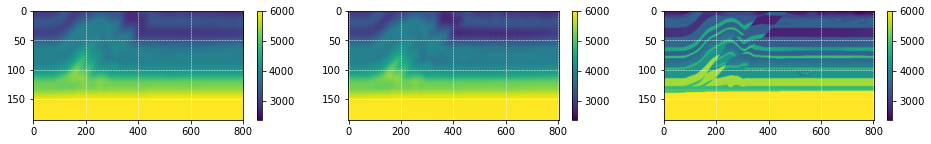

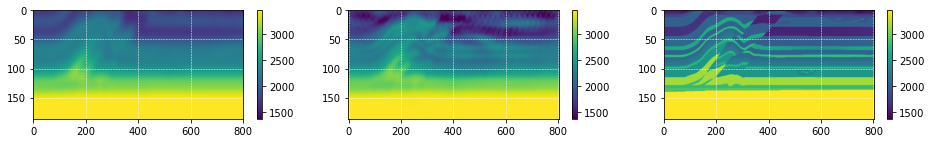

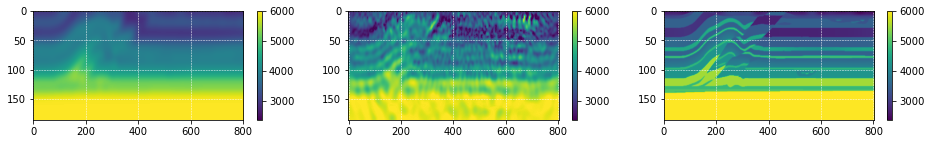

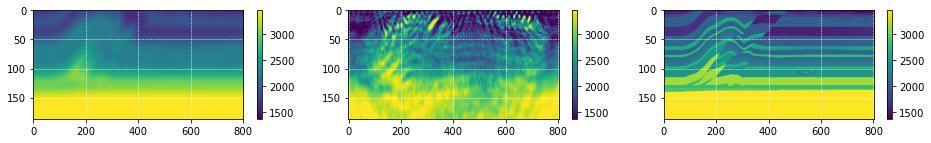

In [8]:
#plot
res=read('res_pz-pzpx_2parascal/model_final',n=(3*nx,nz))

clip=[2365,6000]
plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(init[:,:nx],clip=clip)
plt.subplot(1,3,2); imshow(res[:,:nx],clip=clip)
plt.subplot(1,3,3); imshow(true[:,:nx],clip=clip)

clip=[1364,3462]
plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(init[:,nx:2*nx],clip=clip)
plt.subplot(1,3,2); imshow(res[:,nx:2*nx],clip=clip)
plt.subplot(1,3,3); imshow(true[:,nx:2*nx],clip=clip)

#plot
res=read('res_pz-pzpx_2parascal_contd/model_final',n=(3*nx,nz))

clip=[2365,6000]
plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(init[:,:nx],clip=clip)
plt.subplot(1,3,2); imshow(res[:,:nx],clip=clip)
plt.subplot(1,3,3); imshow(true[:,:nx],clip=clip)

clip=[1364,3462]
plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(init[:,nx:2*nx],clip=clip)
plt.subplot(1,3,2); imshow(res[:,nx:2*nx],clip=clip)
plt.subplot(1,3,3); imshow(true[:,nx:2*nx],clip=clip)

## Initial = 1D

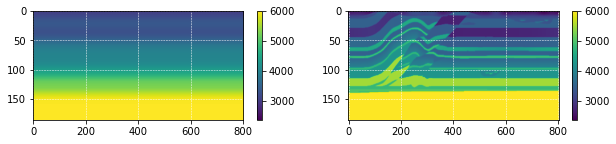

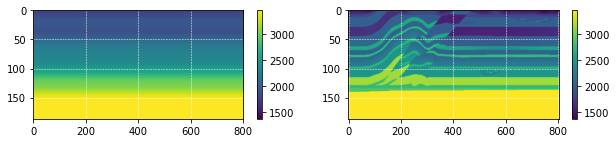

In [9]:
#plot
oned=read('1d',n=(3*nx,nz))

clip=[2365,6000]
plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(oned[:,:nx],clip=clip)
plt.subplot(1,3,2); imshow(true[:,:nx],clip=clip)

clip=[1364,3462]
plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(oned[:,nx:2*nx],clip=clip)
plt.subplot(1,3,2); imshow(true[:,nx:2*nx],clip=clip)

In [21]:
#!cd res_obs; for su in `ls Ru_Shot00??.su`; do suwind < $su key=trid min=22 max=22 > ex_$su; done

make_FWIrun_ALFAHD(resdir='res_1d_pz-ex_2parascal',tag='52',np=20,nthreads=1,setup_more=[
    "FILE_MODEL          '1d'",
    "FILE_DATA_PREFIX    'res_obs/ex_Ru_Shot'",
    "NBATCH               39",
    "SCOMP                pz",
    "PARAMETER           'vp:2365:5990 vs:1364:3462'",
    "IF_PARA_SCAL         T",
    "SMOOTHING            Laplacian", "LAP_FRAC      '0.1 0.1 0.1'",
    "JOB                  optimization "
]) #--> 53549

slmsub run_52.slm


In [7]:
!cat res_1d_pz-ex_2parascal/optimization.log

 **********************************************************************
    LIMITED-MEMORY BFGS ALGORITHM
 **********************************************************************
     Min descent allowed      =1.0000E-08
     Max iterates allowed     =  120
     Max linesearches allowed =   12
     Max gradients allowed    =  150
     Linesearch scaler        =3.81179184E+20
     Initial gradient L1norm (║g0║₁)  =4.2773E+01
 **********************************************************************
         LinS#  Grad#     α    pert%       f                            g·d   Wolfe_cond
  Iter#         Grad#          curr%       f    f/f0(%) ║g║₁/║g0║₁(%)   g·d
     0             1                 1.6321E+02 100.000  100.000     -2.46E-02
            1      2  1.00E+00       1.6254E+02                      -2.43E-02    T  F
            2      3  1.00E+01       1.5737E+02                      -1.75E-02    T  T
     1             3                 1.5737E+02  96.420   80.186     -9.16E-01
 ---

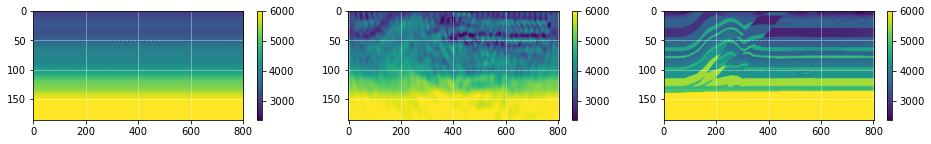

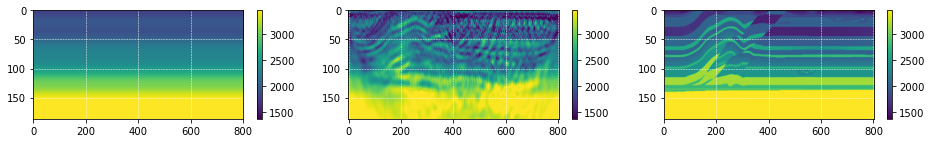

In [10]:
#plot
res=read('res_1d_pz-ex_2parascal/model_final',n=(3*nx,nz))

clip=[2365,6000]
plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(oned[:,:nx],clip=clip)
plt.subplot(1,3,2); imshow(res[:,:nx],clip=clip)
plt.subplot(1,3,3); imshow(true[:,:nx],clip=clip)

clip=[1364,3462]
plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(oned[:,nx:2*nx],clip=clip)
plt.subplot(1,3,2); imshow(res[:,nx:2*nx],clip=clip)
plt.subplot(1,3,3); imshow(true[:,nx:2*nx],clip=clip)

## Initial = another1D

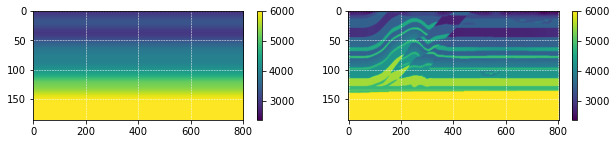

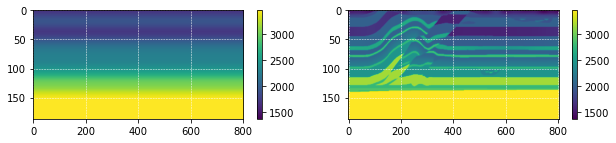

In [11]:
#oned=np.tile(init[:,   600],(nx,1)).T; oned.T.astype('float32').tofile('vp.aut1d')
#oned=np.tile(init[:,nx+600],(nx,1)).T; oned.T.astype('float32').tofile('vs.aut1d')
#!cat vp.aut1d vs.aut1d one > aut1d

oned=read('aut1d',n=(3*nx,nz))

clip=[2365,6000]
plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(oned[:,:nx],clip=clip)
plt.subplot(1,3,2); imshow(true[:,:nx],clip=clip)

clip=[1364,3462]
plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(oned[:,nx:2*nx],clip=clip)
plt.subplot(1,3,2); imshow(true[:,nx:2*nx],clip=clip)

In [12]:
#!cd res_obs; for su in `ls Ru_Shot00??.su`; do suwind < $su key=trid min=22 max=22 > ex_$su; done

make_FWIrun_ALFAHD(resdir='res_aut1d_pz-ex_2parascal',tag='62',np=20,nthreads=1,setup_more=[
    "FILE_MODEL          'aut1d'",
    "FILE_DATA_PREFIX    'res_obs/ex_Ru_Shot'",
    "NBATCH               39",
    "SCOMP                pz",
    "PARAMETER           'vp:2365:5990 vs:1364:3462'",
    "IF_PARA_SCAL         T",
    "SMOOTHING            Laplacian", "LAP_FRAC      '0.1 0.1 0.1'",
    "JOB                  optimization "
]) #--> 53552

slmsub run_62.slm


In [13]:
!cat res_aut1d_pz-ex_2parascal/optimization.log

 **********************************************************************
    LIMITED-MEMORY BFGS ALGORITHM
 **********************************************************************
     Min descent allowed      =1.0000E-08
     Max iterates allowed     =  120
     Max linesearches allowed =   12
     Max gradients allowed    =  150
     Linesearch scaler        =3.14960507E+20
     Initial gradient L1norm (║g0║₁)  =4.3071E+01
 **********************************************************************
         LinS#  Grad#     α    pert%       f                            g·d   Wolfe_cond
  Iter#         Grad#          curr%       f    f/f0(%) ║g║₁/║g0║₁(%)   g·d
     0             1                 1.3060E+02 100.000  100.000     -3.41E-02
            1      2  1.00E+00       1.2844E+02                      -3.52E-02    T  F
            2      3  1.00E+01       1.1173E+02                      -2.96E-02    T  T
     1             3                 1.1173E+02  85.554   96.579     -3.71E+00
 ---

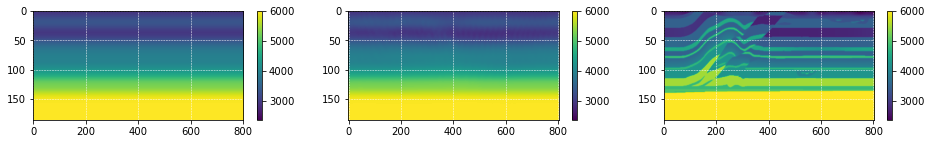

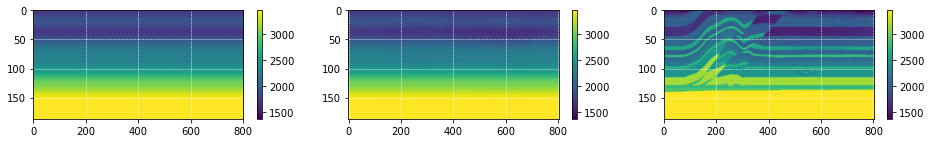

In [14]:
#plot
res=read('res_aut1d_pz-ex_2parascal/model_final',n=(3*nx,nz))

clip=[2365,6000]
plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(oned[:,:nx],clip=clip)
plt.subplot(1,3,2); imshow(res[:,:nx],clip=clip)
plt.subplot(1,3,3); imshow(true[:,:nx],clip=clip)

clip=[1364,3462]
plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(oned[:,nx:2*nx],clip=clip)
plt.subplot(1,3,2); imshow(res[:,nx:2*nx],clip=clip)
plt.subplot(1,3,3); imshow(true[:,nx:2*nx],clip=clip)

In [ ]:
plt.figure(figsize=(9,5))
plt.subplot(1,3,1); ix=500
plt.plot(true[:,nx+ix],z,'k'); plt.plot(even_better[:,nx+ix],z); plt.plot(init[:,nx+ix],z)
plt.xlim([300,1300])
plt.gca().invert_yaxis()

plt.subplot(1,3,2); ix=1000
plt.plot(true[:,nx+ix],z,'k'); plt.plot(even_better[:,nx+ix],z); plt.plot(init[:,nx+ix],z)
plt.xlim([600,1600])
plt.gca().invert_yaxis()

plt.subplot(1,3,3); ix=1250
plt.plot(true[:,nx+ix],z,'k'); plt.plot(even_better[:,nx+ix],z); plt.plot(init[:,nx+ix],z)
plt.xlim([300,1300])
plt.gca().invert_yaxis()

## Data=corrupted, Initial=init

### pz-ex

In [7]:
make_FWIrun_ALFAHD(resdir='res_corrptd_pz-ex_2parascal',tag='12',np=20,nthreads=1,setup_more=[
    "FILE_MODEL          'init'",
    "FILE_DATA_PREFIX    'res_obs_corrupted/ex_Ru_Shot'",
    "NBATCH               39",
    "SCOMP                pz",
    "PARAMETER           'vp:2365:5990 vs:1364:3462'",
    "IF_PARA_SCAL         T",
    "SMOOTHING            Laplacian", "LAP_FRAC      '0.1 0.1 0.1'",
    "JOB                  optimization "
]) #--> 53606

slmsub run_12.slm


In [8]:
!cat res_corrptd_pz-ex_2parascal/optimization.log

 **********************************************************************
    LIMITED-MEMORY BFGS ALGORITHM
 **********************************************************************
     Min descent allowed      =1.0000E-08
     Max iterates allowed     =  120
     Max linesearches allowed =   12
     Max gradients allowed    =  150
     Linesearch scaler        =1.34287305E+20
     Initial gradient L1norm (║g0║₁)  =4.2682E+01
 **********************************************************************
         LinS#  Grad#     α    pert%       f                            g·d   Wolfe_cond
  Iter#         Grad#          curr%       f    f/f0(%) ║g║₁/║g0║₁(%)   g·d
     0             1                 6.1555E+01 100.000  100.000     -2.83E-02
            1      2  1.00E+00       6.0329E+01                      -2.90E-02    T  F
            2      3  1.00E+01       4.9042E+01                      -2.52E-02    T  T
     1             3                 4.9042E+01  79.671   91.031     -2.81E+00
 ---

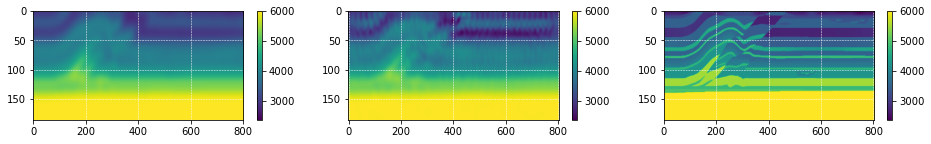

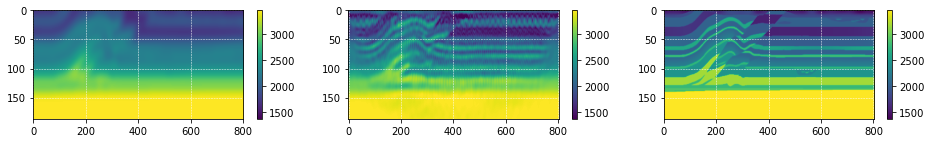

In [8]:
#plot
res=read('res_corrptd_pz-ex_2parascal/model_final',n=(3*nx,nz))

clip=[2365,6000]
plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(init[:,:nx],clip=clip)
plt.subplot(1,3,2); imshow(res[:,:nx],clip=clip)
plt.subplot(1,3,3); imshow(true[:,:nx],clip=clip)

clip=[1364,3462]
plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(init[:,nx:2*nx],clip=clip)
plt.subplot(1,3,2); imshow(res[:,nx:2*nx],clip=clip)
plt.subplot(1,3,3); imshow(true[:,nx:2*nx],clip=clip)

### pz-px

In [9]:
make_FWIrun_ALFAHD(resdir='res_corrptd_pz-px_2parascal',tag='22',np=20,nthreads=1,setup_more=[
    "FILE_MODEL          'init'",
    "FILE_DATA_PREFIX    'res_obs_corrupted/convtd_px_Ru_Shot'",
    "NBATCH               39",
    "SCOMP                pz",
    "PARAMETER           'vp:2365:5990 vs:1364:3462'",
    "IF_PARA_SCAL         T",
    "SMOOTHING            Laplacian", "LAP_FRAC      '0.1 0.1 0.1'",
    "JOB                  optimization "
]) #--> 53650

slmsub run_22.slm


In [7]:
!cat res_corrptd_pz-px_2parascal/optimization.log

 **********************************************************************
    LIMITED-MEMORY BFGS ALGORITHM
 **********************************************************************
     Min descent allowed      =1.0000E-08
     Max iterates allowed     =  120
     Max linesearches allowed =   12
     Max gradients allowed    =  150
     Linesearch scaler        =2.84728251E+13
     Initial gradient L1norm (║g0║₁)  =4.4675E+01
 **********************************************************************
         LinS#  Grad#     α    pert%       f                            g·d   Wolfe_cond
  Iter#         Grad#          curr%       f    f/f0(%) ║g║₁/║g0║₁(%)   g·d
     0             1                 5.5971E+01 100.000  100.000     -2.63E-02
            1      2  1.00E+00       5.4900E+01                      -2.66E-02    T  F
            2      3  1.00E+01       4.5089E+01                      -2.36E-02    T  T
     1             3                 4.5089E+01  80.558   90.513     -2.97E+00
 ---

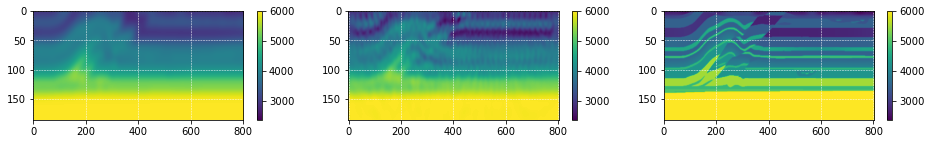

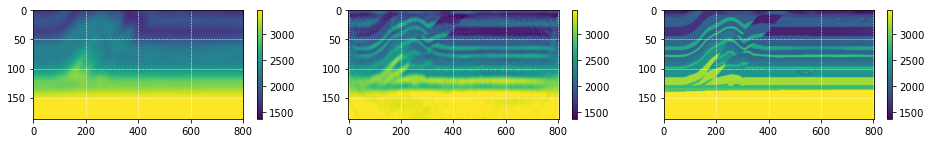

In [8]:
#plot
res=read('res_corrptd_pz-px_2parascal/model_final',n=(3*nx,nz))

clip=[2365,6000]
plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(init[:,:nx],clip=clip)
plt.subplot(1,3,2); imshow(res[:,:nx],clip=clip)
plt.subplot(1,3,3); imshow(true[:,:nx],clip=clip)

clip=[1364,3462]
plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(init[:,nx:2*nx],clip=clip)
plt.subplot(1,3,2); imshow(res[:,nx:2*nx],clip=clip)
plt.subplot(1,3,3); imshow(true[:,nx:2*nx],clip=clip)

### pz-px w/ SMTH

In [12]:
make_FWIrun_ALFAHD(resdir='res_corrptd_pz-px_2parascal_SMTH',tag='23',np=20,nthreads=1,setup_more=[
    "FILE_MODEL          'init'",
    "FILE_DATA_PREFIX    'res_obs_corrupted/convtd_px_Ru_Shot'",
    "NBATCH               39",
    "SCOMP                pz",
    "PARAMETER           'vp:2365:5990 vs:1364:3462'",
    "IF_PARA_SCAL         T",
    "SMOOTHING            Laplacian", "LAP_FRAC      '0.5 0.5 0.5'",
    "JOB                  optimization "
]) #--> 53651

slmsub run_23.slm


In [9]:
!cat res_corrptd_pz-px_2parascal_SMTH/optimization.log

 **********************************************************************
    LIMITED-MEMORY BFGS ALGORITHM
 **********************************************************************
     Min descent allowed      =1.0000E-08
     Max iterates allowed     =  120
     Max linesearches allowed =   12
     Max gradients allowed    =  150
     Linesearch scaler        =3.20090449E+13
     Initial gradient L1norm (║g0║₁)  =4.5038E+01
 **********************************************************************
         LinS#  Grad#     α    pert%       f                            g·d   Wolfe_cond
  Iter#         Grad#          curr%       f    f/f0(%) ║g║₁/║g0║₁(%)   g·d
     0             1                 6.2923E+01 100.000  100.000     -2.48E-02
            1      2  1.00E+00       6.1804E+01                      -2.51E-02    T  F
            2      3  1.00E+01       5.1497E+01                      -2.27E-02    T  F
            3      4  1.00E+02       6.8005E+01                      -5.27E-03    F

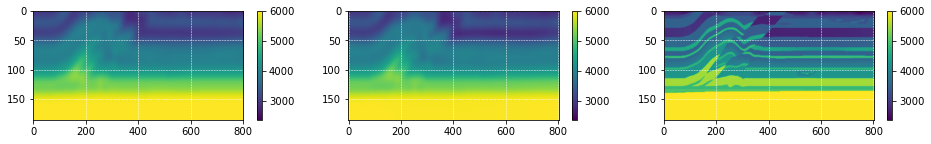

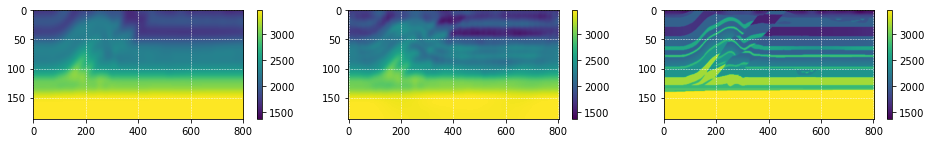

In [10]:
#plot
res=read('res_corrptd_pz-px_2parascal_SMTH/model_Iter11',n=(3*nx,nz))

clip=[2365,6000]
plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(init[:,:nx],clip=clip)
plt.subplot(1,3,2); imshow(res[:,:nx],clip=clip)
plt.subplot(1,3,3); imshow(true[:,:nx],clip=clip)

clip=[1364,3462]
plt.figure(figsize=(16,2))
plt.subplot(1,3,1); imshow(init[:,nx:2*nx],clip=clip)
plt.subplot(1,3,2); imshow(res[:,nx:2*nx],clip=clip)
plt.subplot(1,3,3); imshow(true[:,nx:2*nx],clip=clip)